# Data Analysis


<Container object of 10 artists>

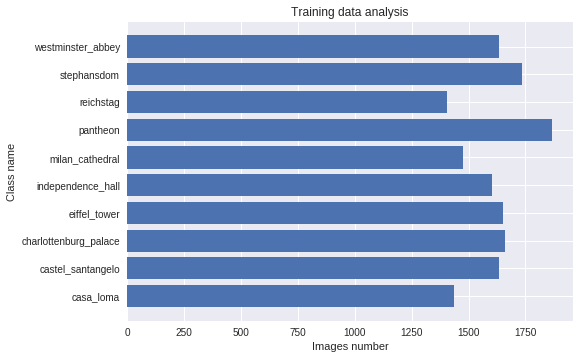

In [0]:
#Training data analysis
values= []
# path joining version for other paths
for i in range (0,10):
  DIR = '/content/train/'+names[i]
  values.append(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))


fig, ax = plt.subplots()
ax.set( xlabel='Images number', ylabel='Class name',
       title='Training data analysis')
ax.barh(names, values,)


<Container object of 10 artists>

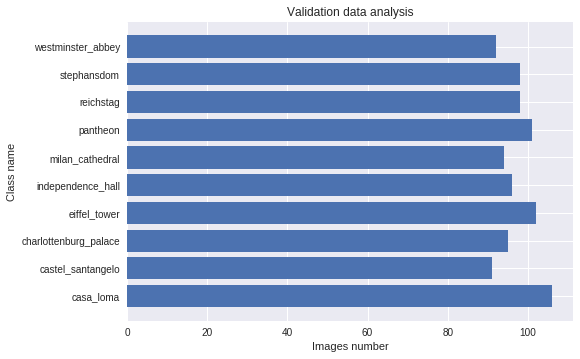

In [0]:
#Validation data analysis
values= []
# path joining version for other paths
for i in range (0,10):
  DIR = '/content/validation/'+names[i]
  values.append(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))


fig, ax = plt.subplots()
ax.set( xlabel='Images number', ylabel='Class name',
       title='Validation data analysis')
ax.barh(names, values,)


<Container object of 10 artists>

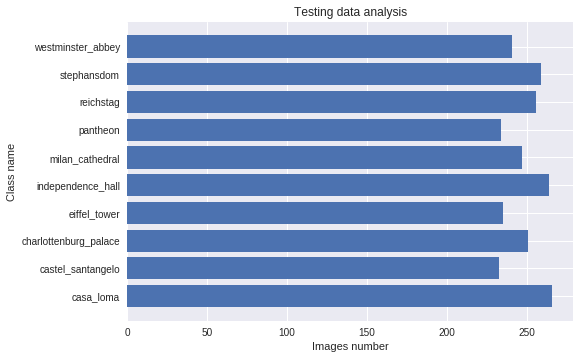

In [0]:
#Testing data analysis
values= []
# path joining version for other paths
for i in range (0,10):
  DIR = '/content/test1/'+names[i]
  values.append(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))


fig, ax = plt.subplots()
ax.set( xlabel='Images number', ylabel='Class name',
       title='Testing data analysis')
ax.barh(names, values,)


# Imports


In [0]:
%matplotlib inline

import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import glob
import pandas as pd
from keras import applications
from keras.utils.np_utils import to_categorical 
from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
import os, os.path

sns.set()

# Data preprocessing

In [6]:
# Pixel values rescaling from [0, 255] to [0, 1] interval
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,       # Randomly applies shearing transformation
    zoom_range =0.2,        
    horizontal_flip=True)  # Randomly flip the images)
test_datagen = ImageDataGenerator(rescale=1./255)

# Retrieve images and their classes for train and validation sets
train_generator = train_datagen.flow_from_directory(
        directory=r"/content/train/",
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
)

validation_generator = test_datagen.flow_from_directory(
        directory=r"/content/validation/",
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        
)


Found 16099 images belonging to 10 classes.
Found 973 images belonging to 10 classes.


# Example of data Augmentation

In [5]:
!mkdir eiffel_tower
!ls /content/

adc.json      sample_data  test1.zip  train.zip   validation.zip
eiffel_tower  test1	   train      validation


In [0]:
img = load_img('/content/train/eiffel_tower/1387736187.jpg')  # PIL image
x = img_to_array(img)  # NumPy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # NumPy array with shape (1, 3, 150, 150)
i = 0
for batch in train_datagen.flow(x, batch_size=1,
                          save_to_dir='/content/eiffel_tower/', save_prefix='eiffel_tower', save_format='jpeg'):
    i += 1
    if i >= 20:
        break

<class 'numpy.ndarray'>
(1024, 768, 3)


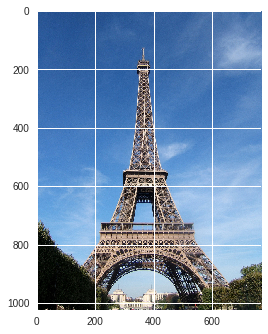

In [10]:
x = img_to_array(img)
print(type(x))
print(x.shape)
plt.imshow(x/255.)

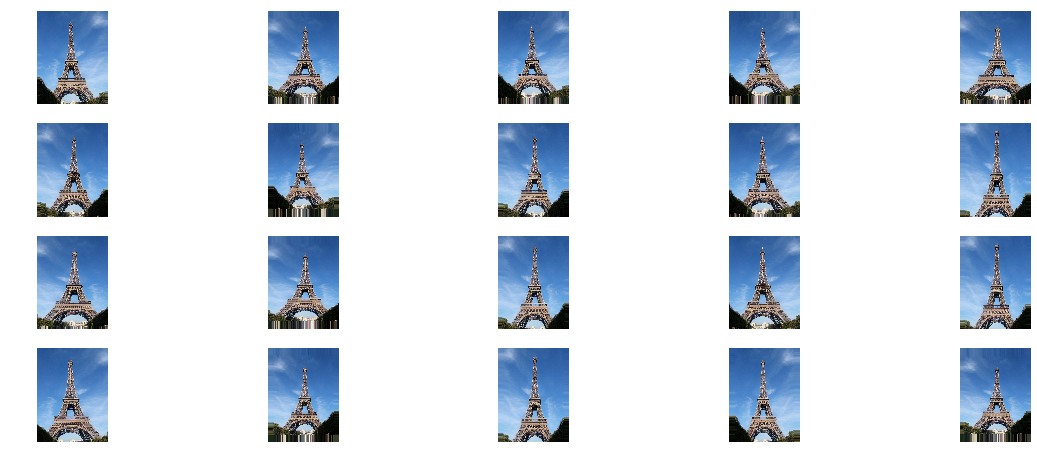

In [11]:
images = []
for img_path in glob.glob('/content/eiffel_tower/*.jpeg'):
    images.append(mpimg.imread(img_path))
    
fig = plt.figure(figsize=(20, 10))

columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.axis('off')
    plt.imshow(image)
    
fig.savefig('/content/eiffel_tower/transformations_example.svg', format='svg', dpi=1200)

# CNN Sequential Model


In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 112, 112, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        18496     
__________

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
!mkdir Models

In [0]:
# Model saving callback# Model 
checkpointer = ModelCheckpoint(filepath='/content/Models/basic_cnn.h5', monitor='val_acc', verbose=1, save_best_only=True)

In [0]:
#Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=4)


In [0]:
train_samples = 16099
validation_samples = 973 
epochs=50
batch_size =32

# Training Basic CNN


In [13]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_samples // batch_size,
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        verbose=2,
        validation_data=validation_generator,
        validation_steps=validation_samples // batch_size,)

Epoch 1/50
 - 477s - loss: 1.6441 - acc: 0.4440 - val_loss: 1.2519 - val_acc: 0.5729

Epoch 00001: val_acc improved from -inf to 0.57292, saving model to /content/Models/basic_cnn.h5
Epoch 2/50
 - 462s - loss: 1.0821 - acc: 0.6380 - val_loss: 1.2534 - val_acc: 0.5990

Epoch 00002: val_acc improved from 0.57292 to 0.59896, saving model to /content/Models/basic_cnn.h5
Epoch 3/50
 - 451s - loss: 0.8853 - acc: 0.7046 - val_loss: 1.0015 - val_acc: 0.7010

Epoch 00003: val_acc improved from 0.59896 to 0.70104, saving model to /content/Models/basic_cnn.h5
Epoch 4/50
 - 444s - loss: 0.7928 - acc: 0.7361 - val_loss: 0.8001 - val_acc: 0.7542

Epoch 00004: val_acc improved from 0.70104 to 0.75417, saving model to /content/Models/basic_cnn.h5
Epoch 5/50
 - 442s - loss: 0.7514 - acc: 0.7539 - val_loss: 0.8016 - val_acc: 0.7490

Epoch 00005: val_acc did not improve from 0.75417
Epoch 6/50
 - 448s - loss: 0.7330 - acc: 0.7588 - val_loss: 0.6581 - val_acc: 0.8250

Epoch 00006: val_acc improved from 0.

In [0]:
model.load_weights("/content/Models/basic_cnn.h5")

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("Basic_CNN.json", "w") as json_file:
    json_file.write(model_json)

## Evaluation

In [16]:
test_generator = test_datagen.flow_from_directory(
    directory=r"/content/test1/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    shuffle = False,
)

Found 2486 images belonging to 10 classes.


In [17]:
# loss and accuracy
test_samples=2486
model.evaluate_generator(test_generator, test_samples)

[0.704954165287986, 0.8032984714400644]

# Visualization

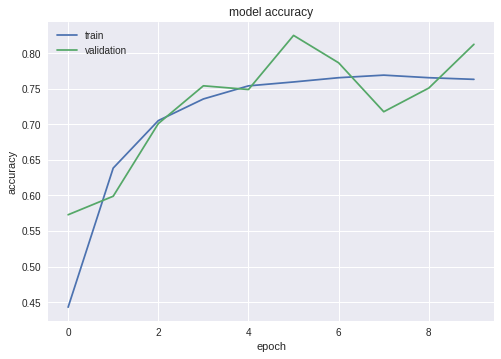

In [18]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


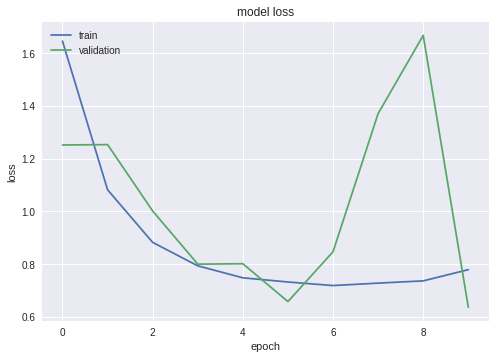

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [20]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'Basic_CNN.json'})
uploaded.SetContentFile('Basic_CNN.json')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1gJitiJfrgl0vGQ1oAxN2v4BJ48N1n66-


In [21]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'basic_cnn.h5'})
uploaded.SetContentFile('/content/Models/basic_cnn.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 163jmzM13F6PnM8hCCt_QsXkX_DxlB62s
